<center><h1>Machine Learning I</h1></center>
<center><h2>Lab 4: Deep Neural Networks </h2></center>



# Preliminaries

As we have seen in the lecture, neural networks are very powerful and flexible machine learning models. However, they are sensitive to the design choices. In this lab, we will start understanding how various hyperparameter settings can affect the learning behaviour of a typical deep neural network model, i.e multilayer perceptron when performing classification. The lab wants to develop the intuitions on how to approach this problem, so flexible approaches are welcome. It is strongly advisable to implement everything yourself and to avoid using standard deep learning libraries (e.g. Scikit-learn, TensorFlow, PyTorch). Please note that some variable names are not very suggestive for the concepts described, but this can be an example also on how you need to understand other people code in any real-world settings.

## The problem

You are requested to perform binary classification on an artificially created dataset. The dataset has two input features (the first two columns from the csv files) and one output (the third column from the csv files). The dataset is split into a training and testing set.

## Let's start

## Question 1 : 
Run the following code and try to get familiar with it.

Training data


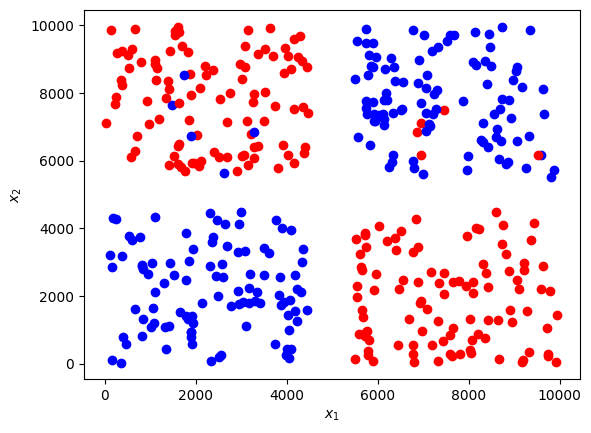

Test data


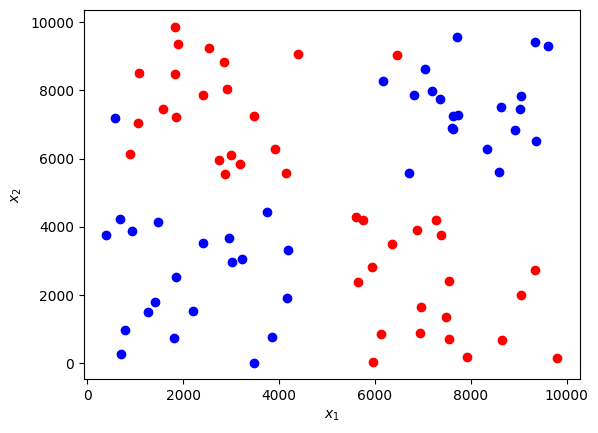


Dense-MLP Epoch  0
Training time:  0:00:00.004731
Testing time: 0:00:00.008570;
 Accuracy train: 0.5390243902439025; 
Accuracy test: 0.5487804878048781; 
Maximum accuracy value: 0.5487804878048781

Dense-MLP Epoch  1
Training time:  0:00:00.007512
Testing time: 0:00:00.009726;
 Accuracy train: 0.5902439024390244; 
Accuracy test: 0.6097560975609756; 
Maximum accuracy value: 0.6097560975609756

Dense-MLP Epoch  2
Training time:  0:00:00.015594
Testing time: 0:00:00.003732;
 Accuracy train: 0.5487804878048781; 
Accuracy test: 0.5121951219512195; 
Maximum accuracy value: 0.6097560975609756

Dense-MLP Epoch  3
Training time:  0:00:00.006485
Testing time: 0:00:00.009021;
 Accuracy train: 0.5853658536585366; 
Accuracy test: 0.5975609756097561; 
Maximum accuracy value: 0.6097560975609756

Dense-MLP Epoch  4
Training time:  0:00:00.014520
Testing time: 0:00:00;
 Accuracy train: 0.5487804878048781; 
Accuracy test: 0.5365853658536586; 
Maximum accuracy value: 0.6097560975609756

Dense-MLP Epoch 

In [2]:
# The code is based on a series of contributions in time from Selima Curci, Shiwei Liu, Decebal Constantin Mocanu, Thomas Hagebols, Ritchie Vink, and a couple of web resources, each of them building on top of the other in a sequential manner. 
# This lab has been developed starting from the last version of it which implements a fully-connectedd MLP https://github.com/SelimaC/Tutorial-SCADS-Summer-School-2020-Scalable-Deep-Learning
# The code was run with Python 3.7.6, Numpy 1.17.2, SciPy 1.4.1, Numba 0.48.0; but other library versions most likely shall work.

import datetime
import json
import time
import numpy as np
import matplotlib.pyplot as plt

# Contains different activation functions and losses to train your MLP model

class Relu:
    @staticmethod
    def activation(z):
        z[z < 0] = 0
        return z

    @staticmethod
    def prime(z):
        z[z < 0] = 0
        z[z > 0] = 1
        return z


class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def prime(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))


class Softmax:
    @staticmethod
    def activation(z):
        """
        https://stackoverflow.com/questions/34968722/softmax-function-python
        Numerically stable version
        """
        exps = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)


class CrossEntropy:
    """
    Used with Softmax activation in final layer
    """

    def delta(self, y_true, y_pred):
        """
        Back propagation error delta
        :return: (array)
        """
        return y_pred - y_true

    @staticmethod
    def loss(y_true, y):
        """
        https://datascience.stackexchange.com/questions/9302/the-cross-entropy-error-function-in-neural-networks
        :param y_true: (array) One hot encoded truth vector.
        :param y: (array) Prediction vector
        :return: (flt)
        """
        y /= y.sum(axis=-1, keepdims=True)
        output = np.clip(y, 1e-7, 1 - 1e-7)
        return np.sum(y_true * - np.log(output), axis=-1).sum() / y.shape[0]


class MSE:
    """
    Mean Squared Error loss function
    """
    def __init__(self, activation_fn=None):
        """
        :param activation_fn: Class object of the activation function.
        """
        if activation_fn:
            self.activation_fn = activation_fn
        else:
            self.activation_fn = NoActivation

    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        """
        :param y_true: (array) One hot encoded truth vector.
        :param y_pred: (array) Prediction vector
        :return: (flt)
        """
        return np.mean((y_pred - y_true) ** 2)

    @staticmethod
    def prime(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        """
        Back propagation error delta
        :return: (array)
        """
        return self.prime(y_true, y_pred) * self.activation_fn.prime(y_pred)


class NoActivation:
    """
    This is a plugin function for no activation.
    f(x) = x * 1
    """

    @staticmethod
    def activation(z):
        """
        :param z: (array) w(x) + b
        :return: z (array)
        """
        return z

    @staticmethod
    def prime(z):
        """
        The prime of z * 1 = 1
        :param z: (array)
        :return: z': (array)
        """
        return np.ones_like(z)

def compute_accuracy(activations, y_test):
    correct_classification = 0
    for j in range(y_test.shape[0]):
        if np.argmax(activations[j]) == np.argmax(y_test[j]):
            correct_classification += 1
    return correct_classification / y_test.shape[0]


def dropout(x, rate):
    noise_shape = x.shape
    noise = np.random.uniform(0., 1., noise_shape)
    keep_prob = 1. - rate
    scale = np.float32(1 / keep_prob)
    keep_mask = noise >= rate
    return x * scale * keep_mask, keep_mask


class Dense_MLP:
    def __init__(self, dimensions, activations):
        """
        :param dimensions: (tpl/ list) Dimensions of the neural net. (input, hidden layer, output)
        :param activations: (tpl/ list) Activations functions.
        Example of three hidden layer with
        - 3312 input features
        - 3000 hidden neurons
        - 3000 hidden neurons
        - 3000 hidden neurons
        - 5 output classes
        layers -->    [1,        2,     3,     4,     5]
        ----------------------------------------
        dimensions =  (3312,     3000,  3000,  3000,  5)
        activations = (          Relu,  Relu,  Relu,  Sigmoid)
        """
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.momentum = None
        self.weight_decay = None
        self.dropout_rate = 0.  # dropout rate
        self.dimensions = dimensions

        self.save_filename = ""
       

        # Weights and biases are initiated by index. For a one hidden layer net you will have a w[1] and w[2]
        self.w = {}
        self.b = {}
        self.pdw = {}
        self.pdd = {}

        # Activations are also initiated by index. For the example we will have activations[2] and activations[3]
        self.activations = {}
        for i in range(len(dimensions) - 1):
            # He uniform initialization
            limit = np.sqrt(6. / float(dimensions[i]))
            self.w[i + 1] = np.random.uniform(-limit, limit, (dimensions[i], dimensions[i + 1]))
            self.b[i + 1] = np.zeros(dimensions[i + 1])
            self.activations[i + 2] = activations[i]

    def _feed_forward(self, x, drop=False):
        """
        Execute a forward feed through the network.
        :param x: (array) Batch of input data vectors.
        :return: (tpl) Node outputs and activations per layer. The numbering of the output is equivalent to the layer numbers.
        """
        # w(x) + b
        z = {}

        # activations: f(z)
        a = {1: x}  # First layer has no activations as input. The input x is the input.
        masks = {}

        for i in range(1, self.n_layers):
            z[i + 1] = a[i] @ self.w[i] + self.b[i]
            a[i + 1] = self.activations[i + 1].activation(z[i + 1])
            if drop:
                if i < self.n_layers - 1:
                    # apply dropout
                    a[i + 1], keep_mask = dropout(a[i + 1], self.dropout_rate)
                    masks[i + 1] = keep_mask

        return z, a, masks

    def _back_prop(self, z, a, masks, y_true):
        """
        The input dicts keys represent the layers of the net.
        a = { 1: x,
              2: f(w1(x) + b1)
              3: f(w2(a2) + b2)
              4: f(w3(a3) + b3)
              5: f(w4(a4) + b4)
              }
        :param z: (dict) w(x) + b
        :param a: (dict) f(z)
        :param y_true: (array) One hot encoded truth vector.
        :return:
        """
        keep_prob = 1.
        if self.dropout_rate > 0:
            keep_prob = np.float32(1. - self.dropout_rate)

        # Determine partial derivative and delta for the output layer.
        # delta output layer
        delta = self.loss.delta(y_true, a[self.n_layers])
        dw = np.dot(a[self.n_layers - 1].T, delta)

        update_params = {
            self.n_layers - 1: (dw, np.mean(delta, axis=0))
        }

        # In case of three layer net will iterate over i = 2 and i = 1
        # Determine partial derivative and delta for the rest of the layers.
        # Each iteration requires the delta from the previous layer, propagating backwards.
        for i in reversed(range(2, self.n_layers)):
            # dropout for the backpropagation step
            if keep_prob != 1:
                delta = (delta @ self.w[i].transpose()) * self.activations[i].prime(z[i])
                delta = delta * masks[i]
                delta /= keep_prob
            else:
                delta = (delta @ self.w[i].transpose()) * self.activations[i].prime(z[i])

            dw = np.dot(a[i - 1].T, delta)

            update_params[i - 1] = (dw, np.mean(delta, axis=0))
        for k, v in update_params.items():
            self._update_w_b(k, v[0], v[1])

    def _update_w_b(self, index, dw, delta):
        """
        Update weights and biases.
        :param index: (int) Number of the layer
        :param dw: (array) Partial derivatives
        :param delta: (array) Delta error.
        """

        # perform the update with momentum
        if index not in self.pdw:
            self.pdw[index] = - self.learning_rate * dw
            self.pdd[index] = - self.learning_rate * delta
        else:
            self.pdw[index] = self.momentum * self.pdw[index] - self.learning_rate * dw
            self.pdd[index] = self.momentum * self.pdd[index] - self.learning_rate * delta

        self.w[index] += self.pdw[index] - self.weight_decay * self.w[index]
        self.b[index] += self.pdd[index] - self.weight_decay * self.b[index]

    def fit(self, x, y_true, x_test, y_test, loss, epochs, batch_size, learning_rate=1e-3, momentum=0.9,
            weight_decay=0.0002, dropoutrate=0., testing=True, save_filename=""):
        """
        :param x: (array) Containing parameters
        :param y_true: (array) Containing one hot encoded labels.
        :return (array) A 2D array of metrics (epochs, 3).
        """
        if not x.shape[0] == y_true.shape[0]:
            raise ValueError("Length of x and y arrays don't match")

        

        # Initiate the loss object with the final activation function
        self.loss = loss()
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.dropout_rate = dropoutrate
        self.save_filename = save_filename

        maximum_accuracy = 0

        metrics = np.zeros((epochs, 4))

        for i in range(epochs):
            # Shuffle the data
            seed = np.arange(x.shape[0])
            np.random.shuffle(seed)
            x_ = x[seed]
            y_ = y_true[seed]


            # training
            t1 = datetime.datetime.now()

            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a, masks = self._feed_forward(x_[k:l], True)

                self._back_prop(z, a, masks, y_[k:l])

            t2 = datetime.datetime.now()


            print("\nDense-MLP Epoch ", i)
            print("Training time: ", t2 - t1)

            # test model performance on the test data at each epoch
            # this part is useful to understand model performance and can be commented for production settings
            if (testing):
                t3 = datetime.datetime.now()
                accuracy_test, activations_test = self.predict(x_test, y_test, batch_size)
                accuracy_train, activations_train = self.predict(x, y_true, batch_size)
                t4 = datetime.datetime.now()
                maximum_accuracy = max(maximum_accuracy, accuracy_test)
                loss_test = self.loss.loss(y_test, activations_test)
                loss_train = self.loss.loss(y_true, activations_train)
                metrics[i, 0] = loss_train
                metrics[i, 1] = loss_test
                metrics[i, 2] = accuracy_train
                metrics[i, 3] = accuracy_test

                print(f"Testing time: {t4 - t3};\n Accuracy train: {accuracy_train}; \n"
                      f"Accuracy test: {accuracy_test}; \n"
                      f"Maximum accuracy value: {maximum_accuracy}")

            # save performance metrics values in a file
            if save_filename != "":
                np.savetxt(save_filename +".txt", metrics)


        return metrics

    def predict(self, x_test, y_test, batch_size=100):
        """
        :param x_test: (array) Test input
        :param y_test: (array) Correct test output
        :param batch_size:
        :return: (flt) Classification accuracy
        :return: (array) A 2D array of shape (n_cases, n_classes).
        """
        activations = np.zeros((y_test.shape[0], y_test.shape[1]))
        for j in range(x_test.shape[0] // batch_size):
            k = j * batch_size
            l = (j + 1) * batch_size
            _, a_test, _ = self._feed_forward(x_test[k:l], drop=False)
            activations[k:l] = a_test[self.n_layers]
        accuracy = compute_accuracy(activations, y_test)
        return accuracy, activations

def plotData(dataset):
    for i in range(dataset.shape[0]):
        if (dataset[i,2]==1):
            plt.scatter(dataset[i,0],dataset[i,1],c='r')
        else:
            plt.scatter(dataset[i, 0],dataset[i,1],c='b')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.show()



    
if __name__ == "__main__":

    sum_training_time = 0
    runs = 1

    for runindex in range(runs):
        # load data
        train_data = np.loadtxt("Lab4train.csv")
        test_data = np.loadtxt("Lab4test.csv")
        
        print ("Training data")
        plotData(train_data)
        print ("Test data")
        plotData(test_data)      
        
        x_train = train_data[:, :2]
        y_train = np.zeros((x_train.shape[0], 2))
        for i in range(x_train.shape[0]):
            y_train[i, int(train_data[i, 2])] = 1

        x_test = test_data[:, :2]
        y_test = np.zeros((x_test.shape[0], 2))
        for i in range(x_test.shape[0]):
            y_test[i, int(test_data[i, 2])] = 1

        temp=x_train.copy()
        x_train = (x_train-np.min(x_train)) / (np.max(x_train)-np.min(x_train))
        x_test = (x_test-np.min(temp)) / (np.max(temp)-np.min(temp))

    
        

        #set MLP model hyper-parameters
        no_hidden_neurons_layer = 4
        no_training_epochs = 100
        batch_size = 10
        dropout_rate = 0.1
        learning_rate = 0.001
        momentum = 0.9
        weight_decay = 0.002

        np.random.seed(runindex)

        # create Dense-MLP ( fully-connected MLP)
        dense_mlp = Dense_MLP((x_train.shape[1], no_hidden_neurons_layer, y_train.shape[1]),
                              (Relu, Sigmoid))

        start_time = time.time()
        # train Dense-MLP
        dense_mlp.fit(x_train, y_train, x_test, y_test, loss=MSE, epochs=no_training_epochs, batch_size=batch_size, learning_rate=learning_rate,
                      momentum=momentum, weight_decay=weight_decay, dropoutrate=dropout_rate, testing=True,
                      save_filename="dense_mlp_rand_"+str(runindex))
        step_time = time.time() - start_time
        sum_training_time += step_time
        print("\nTotal training time: ", step_time)

        # test Dense-MLP
        accuracy, _ = dense_mlp.predict(x_test, y_test, batch_size=20)

        print("\nAccuracy of the last epoch on the testing data: ", accuracy)
    print(f"Average training time over {runs} runs is {sum_training_time/runs} seconds")

## Question 2 - Hyper-parameters optimization
In the example from Question 1, the maximum accuracy of the model on the test dataset is 64.36%. 
Try to perform hyper-parameters optimization (e.g. learning rate, number of layers, activation function, loss function, etc.) in order to maximize the accuracy on the test dataset. Please note that there are many ways to set the hyper-parameters to improve the accuracy. You need to find just one solution which leads to an accuracy higher than 64.36%. Below is an example of what I was able to find. Would you be able to obtain 100% acuracy? Why?

Hint: while random search can lead to obtaining faster results, try to take a systematic grid-search approach. Try to make heatmaps or parallel coordinates plots to vizualize and understand the effect of various hyper-parameters on the learning behaviour.



Training data


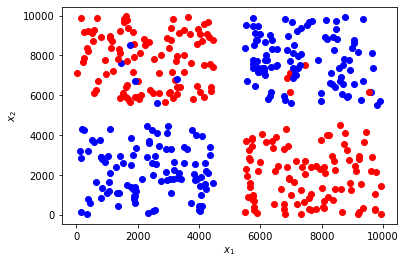

Test data


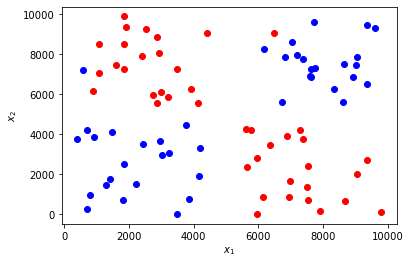


Dense-MLP Epoch  0
Training time:  0:00:00.008718
Testing time: 0:00:00.003137;
 Accuracy train: 0.6414634146341464; 
Accuracy test: 0.6219512195121951; 
Maximum accuracy value: 0.6219512195121951

Dense-MLP Epoch  1
Training time:  0:00:00.004417
Testing time: 0:00:00.003468;
 Accuracy train: 0.7926829268292683; 
Accuracy test: 0.7560975609756098; 
Maximum accuracy value: 0.7560975609756098

Dense-MLP Epoch  2
Training time:  0:00:00.004517
Testing time: 0:00:00.004046;
 Accuracy train: 0.775609756097561; 
Accuracy test: 0.8292682926829268; 
Maximum accuracy value: 0.8292682926829268

Dense-MLP Epoch  3
Training time:  0:00:00.004409
Testing time: 0:00:00.003998;
 Accuracy train: 0.7902439024390244; 
Accuracy test: 0.7682926829268293; 
Maximum accuracy value: 0.8292682926829268

Dense-MLP Epoch  4
Training time:  0:00:00.004415
Testing time: 0:00:00.003849;
 Accuracy train: 0.7853658536585366; 
Accuracy test: 0.8536585365853658; 
Maximum accuracy value: 0.8536585365853658

Dense-MLP 

/var/folders/zj/0f_g81n10t98004523rnzmrc0000gn/T/ipykernel_68397/2610132445.py:68: RuntimeWarning: invalid value encountered in true_divide
  y /= y.sum(axis=-1, keepdims=True)


In [5]:
#Your code comes here for question 2. For simplicity, just copy/paste the whole code from Question 1 and mark the places where you have made changes with:
# Question 2 - start answer
# Question 2 - end answer




## Question 3 - initialization
Using the code from Question 2 with the best hyper-parameters settings that you obtained, try to identify the correct place in the code where the weights and biases values are initialized before training. Initialize the weights and biases values to zero and after that train the model. Below is my example, but things may be different in your case. Do you obtained the same learning behaviour as me or not? Is there any reason which can explain this learning behaviour?



Training data


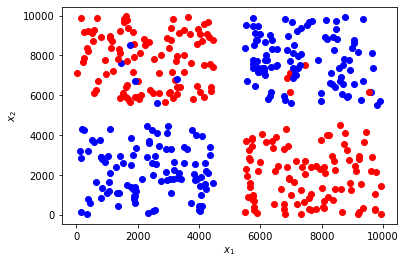

Test data


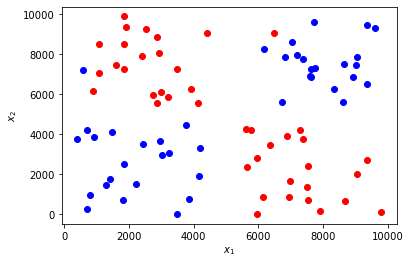


Dense-MLP Epoch  0
Training time:  0:00:00.004213
Testing time: 0:00:00.002890;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  1
Training time:  0:00:00.003890
Testing time: 0:00:00.003170;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  2
Training time:  0:00:00.003769
Testing time: 0:00:00.003547;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  3
Training time:  0:00:00.003714
Testing time: 0:00:00.002824;
 Accuracy train: 0.4902439024390244; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  4
Training time:  0:00:00.003708
Testing time: 0:00:00.003377;
 Accuracy train: 0.4902439024390244; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  5
Training time:  0:00:00.003782
Testing time: 0:00:00.003522;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  6
Training time:  0:00:00.003711
T

/var/folders/zj/0f_g81n10t98004523rnzmrc0000gn/T/ipykernel_68397/693709664.py:68: RuntimeWarning: invalid value encountered in true_divide
  y /= y.sum(axis=-1, keepdims=True)


Testing time: 0:00:00.003679;
 Accuracy train: 0.4902439024390244; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  25
Training time:  0:00:00.003917
Testing time: 0:00:00.003755;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  26
Training time:  0:00:00.003736
Testing time: 0:00:00.003924;
 Accuracy train: 0.4902439024390244; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  27
Training time:  0:00:00.004013
Testing time: 0:00:00.003972;
 Accuracy train: 0.4902439024390244; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  28
Training time:  0:00:00.003870
Testing time: 0:00:00.003950;
 Accuracy train: 0.4902439024390244; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  29
Training time:  0:00:00.004877
Testing time: 0:00:00.004089;
 Accuracy train: 0.4902439024390244; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  30
Training time:  0:00:00.003854
T


Dense-MLP Epoch  76
Training time:  0:00:00.004954
Testing time: 0:00:00.003560;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  77
Training time:  0:00:00.004639
Testing time: 0:00:00.004177;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  78
Training time:  0:00:00.004321
Testing time: 0:00:00.004053;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  79
Training time:  0:00:00.004575
Testing time: 0:00:00.004002;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  80
Training time:  0:00:00.004373
Testing time: 0:00:00.003850;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  81
Training time:  0:00:00.004514
Testing time: 0:00:00.004085;
 Accuracy train: 0.5; 
Accuracy test: 0.5; 
Maximum accuracy value: 0.5

Dense-MLP Epoch  82
Training time:  0:00:00.004354
Testing time: 0:00:00.00

In [7]:
#Your code comes here for Question 3. For simplicity, just copy/paste the whole code from Question 2 and mark the places where you have made changes with:
# Question 3 - start answer
# Question 3 - end answer




## Question 4 - momentum
Using the code from Question 2 with the best hyper-parameters settings that you obtained, try to identify the correct place in the code where you can remove the momentum component of gradient descent. After you remove it, please train the model again. Is there any difference between this learning behaviour on the one obtained at Question 2? Below is my example.



Training data


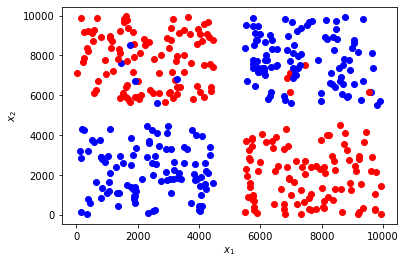

Test data


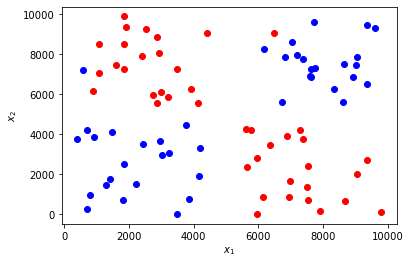


Dense-MLP Epoch  0
Training time:  0:00:00.004859
Testing time: 0:00:00.003151;
 Accuracy train: 0.4073170731707317; 
Accuracy test: 0.4146341463414634; 
Maximum accuracy value: 0.4146341463414634

Dense-MLP Epoch  1
Training time:  0:00:00.004902
Testing time: 0:00:00.003279;
 Accuracy train: 0.3878048780487805; 
Accuracy test: 0.34146341463414637; 
Maximum accuracy value: 0.4146341463414634

Dense-MLP Epoch  2
Training time:  0:00:00.004402
Testing time: 0:00:00.003645;
 Accuracy train: 0.5097560975609756; 
Accuracy test: 0.47560975609756095; 
Maximum accuracy value: 0.47560975609756095

Dense-MLP Epoch  3
Training time:  0:00:00.004615
Testing time: 0:00:00.004218;
 Accuracy train: 0.5292682926829269; 
Accuracy test: 0.4878048780487805; 
Maximum accuracy value: 0.4878048780487805

Dense-MLP Epoch  4
Training time:  0:00:00.004201
Testing time: 0:00:00.003964;
 Accuracy train: 0.7926829268292683; 
Accuracy test: 0.7682926829268293; 
Maximum accuracy value: 0.7682926829268293

Dense-

/var/folders/zj/0f_g81n10t98004523rnzmrc0000gn/T/ipykernel_68397/340496245.py:67: RuntimeWarning: invalid value encountered in true_divide
  y /= y.sum(axis=-1, keepdims=True)


In [8]:
#Your code comes here for question 4. For simplicity, just copy/paste the whole code from Question 2 and mark the places where you have made changes with:
# Question 4 - start answer
# Question 4 - end answer


